In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy.integrate
import matplotlib.pyplot as plt
import math
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('text', usetex=True)
import time
####reactivity parametrization of DT, D3He, DDp, DDn, TT, 3He3He reactions
## Belov et al 2019
def react(T, channel):
    if channel == 'tt':
        return 5.41*1e-14*T**(-2/3)*np.exp(-21.52/T**(1/3))
    elif channel == '3he3he':
        return 1.93*1e-12*T**(-2/3)*np.exp(-54.22/T**(1/3))
    else:
        if channel == 'dt':
            ksi =  np.array([-42.559, 33.312, -9.876,  2.501, -0.414, 0.0,   0.0])
            neta = np.array([0.0,     24.394, -16.909, 7.406, -2.148, 0.411, 0.0])
        if channel == 'd3he':
            ksi =  np.array([-60.504, 53.039, -16.233, 3.980, -0.749, 0.0, 0.004])
            neta = np.array([0.0,     43.244, -31.497, 15.707, -6.055, 1.734, -0.319])
        if channel == 'ddp':
            ksi =  np.array([-41.898, 30.017, -9.150,  2.140, -0.316, 0.0,   0.012])
            neta = np.array([0.0,     24.313, -16.995, 7.572, -2.540, 0.580, -0.068])
        if channel == 'ddn':
            ksi =  np.array([-42.145, 30.484, -9.451,  2.265, -0.346, 0.0,   0.015])
            neta = np.array([0.0,     24.459, -17.170, 7.744, -2.655, 0.630, -0.079])
        t = (np.pi/5.30)*(np.log10(T*1000) -3.65)
        s = sum(ksi[k]*np.cos(k*t)+neta[k]*np.sin(k*t) for k in range(len(ksi)))
        return np.power(10, s)
#############################

In [2]:
def F(s,t_int, num, channel):
    
    # Fusion reaction rates
    r_dd_p = react(s[0],'ddp') 
    r_dd_n = react(s[0],'ddn') 
    r_dt =   react(s[0],'dt')
    r_d3he = react(s[0],'d3he')    
    r_dd =   react(s[0],'ddp') + react(s[0],'ddn')
    r_tt =   react(s[0],'tt')
    r_3he3he=react(s[0],'3he3he')
    
    # Q values and energies for fusion reactions in MeV
    Q_ddp = 4.03; Q_ddn = 3.27; Q_d3he = 18.35;
    E_ddn = 0.82; E_adt = 3.52; E_n1 = 2.45;   E_n2 = 14.07;
    E_att = 3.7766 ; Q3he3he = 12.86; En34 = (2/3)*11.33
    
    
    # D, T and 3He densities in cm^-3
    nd   = -0.5*r_dd   * s[1]*s[1] - r_dt  *s[1]*s[2] -r_d3he*s[1]*s[3]
    nt   = +0.5*r_dd_p * s[1]*s[1] - r_dt  *s[1]*s[2] - 0.5*r_tt*s[2]*s[2]
    n3he = +0.5*r_dd_n * s[1]*s[1] - r_d3he*s[1]*s[3] - 0.5*r_3he3he*s[3]*s[3]
    #na   =       r_dt  *s[1]*s[2]  + 0.5*r_3he3he*s[3]*s[3] + 0.5*r_tt*s[2]*s[2]
    # Energy yield in keV/cm^3 for charged particles
    Ech =  (0.5*r_dd_p * s[1]*s[1]* Q_ddp + r_dt  * s[1]*s[2]* E_adt+
            0.5*r_dd_n * s[1]*s[1]* E_ddn + r_d3he* s[1]*s[3]* Q_d3he+
            0.5*r_3he3he*s[3]*s[3]*Q3he3he + 0.5*r_tt*s[2]*s[2]*E_att)
    
    # Energy yield in MeV/cm^3 for Neutrons
    En =    (0.5*r_dd_n * s[1]*s[1]* E_n1 +  r_dt * s[1]*s[2]* E_n2 +
             0.5*r_tt*s[2]*s[2]*En34)
    
    if channel =='d3he':
        ne = 15e+23 # Electron density in cm^-3, assuming const
    else:
        ne = 10e+23
    ###Bremsstrahlung power radiation losses in Mev/cm^3
    Pbr = 0.334e-17*np.sqrt(s[0])*(s[1]+s[2]+4*s[3])*ne
    
    ### Temperature in keV
    if num == 0:   #### changing Temperature
        
        T =  (2/3)*1e+3*(Ech-Pbr)/(s[1]+s[2]+s[3])
    else:
        T = 0      #### for T = const
    return [T, nd, nt, n3he, Ech, En, Pbr]

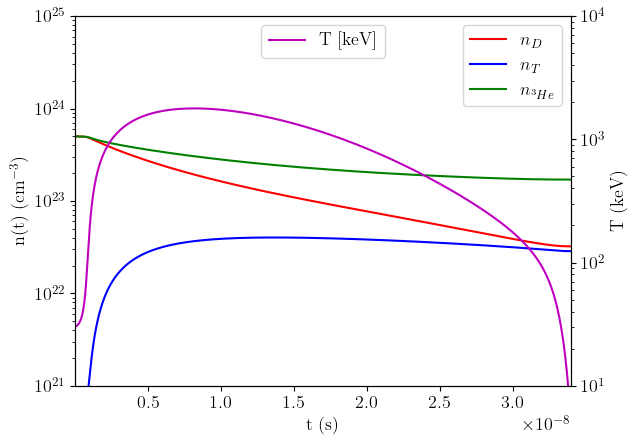

In [3]:
t_min = 1e-12   # start-time in seconds
t_max = 3.4e-8 # finish-time in seconds
t_int = np.linspace(t_min,t_max, 100000) # number of time intervals
#initial concentrations n0 (0,1,2) in keV/cm^3 and Temp(3) and energy Ech(4), En(5), Pbr(6)
n0=[30, 5e+23,1e+13,5e+23, 1e+10, 1e+10, 1e+10] 
s = odeint(F,n0,t_int, args=(0,'d3he'))
#s2 = odeint(F,n0,t_int, args=(1, 'd3he')) at T = const
fig, ax1 = plt.subplots()
ax1.plot(t_int,s[:,1],'r-', linewidth=1.5)
ax1.plot(t_int,s[:,2],'b-', linewidth=1.5)
ax1.plot(t_int,s[:,3],'g-', linewidth=1.5)
ax1.set(ylim=[1e+21, 1e+25], yscale ='log')
#ax1.set(xlim=[1e-9,t_max], xscale='log')
ax1.set(xlim=[t_min,t_max])
ax1.set_ylabel('n(t) (cm$^{-3}$)')
plt.xlabel('t (s)')
plt.legend(['$n_{D}$', '$n_{T}$', '$n_{^{3}He}$'], loc='upper right')
ax2 = ax1.twinx()
ax2.plot(t_int,s[:,0],'m-', linewidth=1.5)
ax2.set(ylabel = 'T (keV)', yscale ='log', ylim = [1e+1, 1e+4])
ax2.legend(['T [keV]'], loc='upper center')
#plt.savefig('DTfuel_burn.jpg', dpi= 1000,bbox_inches='tight')
plt.show()